<a href="https://colab.research.google.com/github/ssnkim1/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_2%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# 오픈소스 기반 데이터 분석 2강 - 데이터 분석을 위한 파이썬 1


In [22]:
# 문제1-2

In [23]:
import requests

def collect_energy_data():
    """
    2015년 1월부터 2024년 12월까지의 에너지 사용량 데이터를 API로부터 수집합니다.
    """
    MY_API_KEY = "6f6e644b49776f7237316677467661"
    BASE_URL = f"http://openapi.seoul.go.kr:8088/{MY_API_KEY}/json/energyUseDataSummaryInfo/1/5"

    # 2015년부터 2024년까지의 '년/월' 리스트 생성
    year_months = []
    for year in range(2015, 2025): # 2025는 포함하지 않음 (2024년까지)
        for month in range(1, 13):
            # 월을 두 자리 문자열로 포맷 (예: 1 -> 01, 12 -> 12)
            year_months.append((str(year), f'{month:02d}'))

    responses = []

    # 첫 번째 호출 성공 여부 확인용 변수
    first_response_status = None
    first_response_json = None

    print("데이터 수집 시작...")

    for year, month in year_months:
        url = f"{BASE_URL}/{year}/{month}"

        try:
            response = requests.get(url, timeout=10) # 타임아웃 10초 설정

            if response.status_code == 200:
                data = response.json()
                # 데이터가 실제로 있는지 확인
                if 'energyUseDataSummaryInfo' in data and data['energyUseDataSummaryInfo'].get('row'):
                    # 필요한 필드만 추출하여 저장 (연도, 월 정보 포함)
                    for item in data['energyUseDataSummaryInfo']['row']:
                        # 날짜 정보 추가
                        item['YEAR'] = year
                        item['MONTH'] = month
                        responses.append(item)

                # 첫 번째 호출 결과를 저장 (성공 확인용)
                if first_response_status is None:
                    first_response_status = response.status_code
                    first_response_json = data

            else:
                # API 호출 실패 시 메시지 출력 (전체 데이터 수집은 계속 진행)
                if first_response_status is None: # 첫 번째 시도 실패 시
                    first_response_status = response.status_code

                print(f"API 호출 실패: {response.status_code} for {year}-{month}")

        except requests.exceptions.RequestException as e:
            # 네트워크 오류, 타임아웃 등 예외 처리
            print(f"API 호출 중 오류 발생: {e} for {year}-{month}")

    # 첫 번째 API 호출 성공/실패 출력 (조건 2 만족)
    print("\n--- 첫 번째 API 호출 성공/실패 확인 ---")
    if first_response_status == 200:
        print("API 호출 성공 (2015년 01월)")
        # 출력 결과가 너무 길어 핵심 정보만 간략히 출력
        print(f"응답 데이터 (일부): {first_response_json.get('energyUseDataSummaryInfo', {}).get('row', 'No data row')}")
    else:
        print(f"API 호출 실패: {first_response_status}")

    return responses

# 데이터 수집 및 첫 번째 호출 결과 확인
raw_data = collect_energy_data()

# 최종 수집된 데이터 개수 확인
print(f"\n총 수집된 유효 데이터 건수: {len(raw_data)}")

데이터 수집 시작...

--- 첫 번째 API 호출 성공/실패 확인 ---
API 호출 성공 (2015년 01월)
응답 데이터 (일부): [{'YEAR': '2015', 'MON': '01', 'MM_TYPE': '개인', 'CNT': '767791', 'EUS': '193784708', 'EUS1': '194781915', 'EUS2': '204969429', 'ECO2_1': '-6090964', 'ECO2_2': '-2582568.736', 'GUS': '59133720', 'GUS1': '57163993', 'GUS2': '68297619', 'GCO2_1': '-3597086', 'GCO2_2': '-8057472.64', 'WUS': '12819757.886', 'WUS1': '12723680.426', 'WUS2': '12899476.73', 'WCO2_1': '8179.308', 'WCO2_2': '2715.530256', 'HUS': '22740838.937', 'HUS1': '23400055.303', 'HUS2': '27090493.875', 'HCO2_1': '-2504435.652', 'HCO2_2': '-33660084.213069', 'REG_DATE': '2015-06-04 17:03:55.0', 'MONTH': '01'}, {'YEAR': '2015', 'MON': '01', 'MM_TYPE': '학교', 'CNT': '1382', 'EUS': '134955565', 'EUS1': '128707423', 'EUS2': '145561511', 'ECO2_1': '-2178902', 'ECO2_2': '-923854.448', 'GUS': '9107197', 'GUS1': '8410968', 'GUS2': '10745416', 'GCO2_1': '-470995', 'GCO2_2': '-1055028.8', 'WUS': '2075819.2', 'WUS1': '2097433.8', 'WUS2': '2133200.8', 'WCO2_1':

In [24]:
# 문제2-1

In [25]:
import pandas as pd

# 1. 수집한 raw_data를 DataFrame으로 변환
df = pd.DataFrame(raw_data)

# 2. 필요한 컬럼만 선택하고 이름을 변경하여 정리
# TY_CD (개인 유형 코드)는 모두 1이므로 제거.
# YEAR_MONTH는 YEAR와 MONTH로 분리했으므로 제거.
# The original column names from the API response are used here.
df = df.rename(columns={
    'MM_TYPE': '에너지_유형',
    'EUS': '사용량'
})
# Select the desired columns using the new names
df = df[['YEAR', 'MONTH', '에너지_유형', '사용량']]


# 3. 데이터 타입 변환: YEAR, MONTH를 정수형으로 변환
df['YEAR'] = df['YEAR'].astype(int)
df['MONTH'] = df['MONTH'].astype(int)

# 4. '사용량' 컬럼을 숫자형으로 변환. 오류 발생 시 NaN으로 처리
df['사용량'] = pd.to_numeric(df['사용량'], errors='coerce')


# 데이터 기본 정보 출력
print("--- DataFrame 기본 정보 ---")
print(df.info())
print("\n--- DataFrame 상위 5개 행 ---")
print(df.head())

--- DataFrame 기본 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   YEAR    600 non-null    int64 
 1   MONTH   600 non-null    int64 
 2   에너지_유형  600 non-null    object
 3   사용량     600 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 18.9+ KB
None

--- DataFrame 상위 5개 행 ---
   YEAR  MONTH   에너지_유형        사용량
0  2015      1       개인  193784708
1  2015      1       학교  134955565
2  2015      1     종교단체     372270
3  2015      1     소상공인   10249618
4  2015      1  공동주택관리소  327102096


In [26]:
# 문제2-2 수정 후

In [27]:
import pandas as pd

# 'raw_data'는 문제 1의 API 호출 결과로 현재 세션에 존재한다고 가정

# 1. 수집한 raw_data를 DataFrame으로 변환
df = pd.DataFrame(raw_data)

# 2. 필요한 컬럼만 선택하고 이름을 변경하여 정리
# 분석의 유연성을 위해 모든 에너지 사용량 컬럼(EUS, GUS, WUS, HUS)을 유지합니다.
# MM_TYPE은 회원 유형이므로 회원_유형으로 변경합니다.
df = df.rename(columns={
    'MM_TYPE': '회원_유형', # <-- '에너지_유형' 대신 '회원_유형'으로 변경
    'EUS': '전기_사용량',
    'GUS': '가스_사용량',
    'WUS': '수도_사용량',
    'HUS': '지역난방_사용량'
})
# 필요한 컬럼만 선택 (MM_TYPE, TY_CD, YEAR_MONTH 등의 불필요한 원본 컬럼은 제거)
df = df[['YEAR', 'MONTH', '회원_유형', '전기_사용량', '가스_사용량', '수도_사용량', '지역난방_사용량']]


# 3. 데이터 타입 변환: YEAR, MONTH를 정수형으로 변환
df['YEAR'] = df['YEAR'].astype(int)
df['MONTH'] = df['MONTH'].astype(int)

# 4. 사용량 컬럼들을 숫자형으로 변환. 오류 발생 시 NaN으로 처리
for col in ['전기_사용량', '가스_사용량', '수도_사용량', '지역난방_사용량']:
    # pd.to_numeric()을 사용하여 안전하게 숫자형으로 변환
    df[col] = pd.to_numeric(df[col], errors='coerce')

# -------------------------------------------------------------------------
# 문제 2-2. 연도별, 계절별 분석을 위해 날짜 컬럼을 활용하여 계절(season) 컬럼을 추가
# -------------------------------------------------------------------------

# 1. 계절(season) 컬럼 추가 함수 정의
def get_season(month):
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else: # 12, 1, 2
        return '겨울'

# 2. 계절 컬럼 생성
df['season'] = df['MONTH'].apply(get_season)

# 3. 데이터 기본 정보 출력 (확인)
print("--- DataFrame 기본 정보 (컬럼명 수정) ---")
print(df.info())
print("\n--- DataFrame 상위 5개 행 ---")
print(df.head())
print("\n--- 계절별 데이터 개수 확인 ---")
print(df['season'].value_counts())


--- DataFrame 기본 정보 (컬럼명 수정) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   YEAR      600 non-null    int64  
 1   MONTH     600 non-null    int64  
 2   회원_유형     600 non-null    object 
 3   전기_사용량    600 non-null    int64  
 4   가스_사용량    600 non-null    float64
 5   수도_사용량    600 non-null    float64
 6   지역난방_사용량  600 non-null    float64
 7   season    600 non-null    object 
dtypes: float64(3), int64(3), object(2)
memory usage: 37.6+ KB
None

--- DataFrame 상위 5개 행 ---
   YEAR  MONTH    회원_유형     전기_사용량      가스_사용량        수도_사용량      지역난방_사용량  \
0  2015      1       개인  193784708  59133720.0  1.281976e+07  2.274084e+07   
1  2015      1       학교  134955565   9107197.0  2.075819e+06  0.000000e+00   
2  2015      1     종교단체     372270     53331.0  5.945000e+03  0.000000e+00   
3  2015      1     소상공인   10249618    536119.0  1.472730e+05  0.00

In [28]:
# 문제3-1

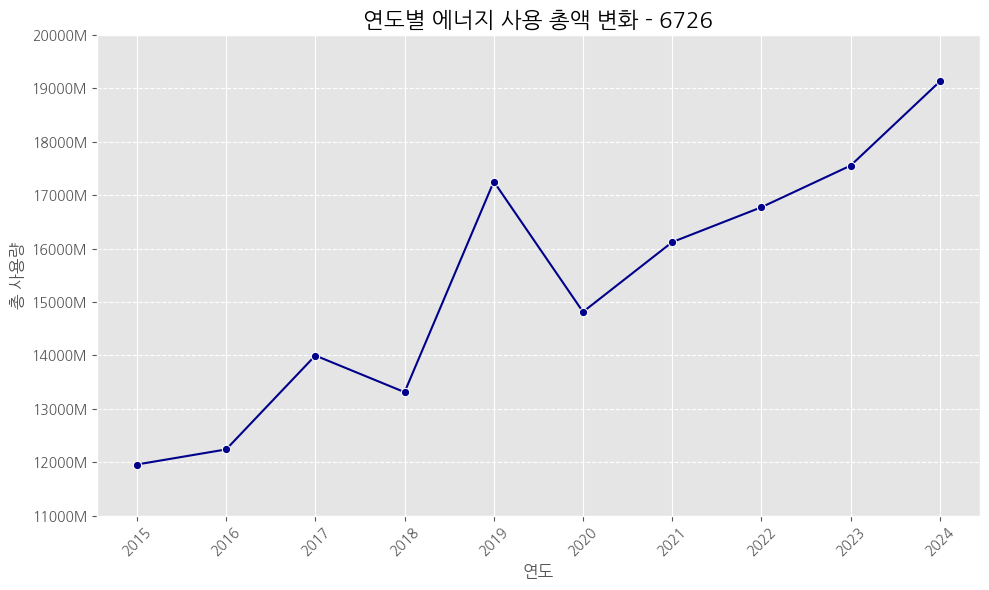

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 1. 폰트 및 스타일 설정 ---
# 폰트 설정 (NanumGothic 설치 및 런타임 재시작이 완료되었다고 가정)
plt.rc('font', family='NanumGothic') # 나눔 고딕 폰트 지정
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지
plt.style.use('ggplot') # 그래프 스타일 설정

# 문제 1과 문제 2의 성공적인 실행으로 'df' DataFrame이 준비되었음을 가정합니다.

if 'df' in locals() or 'df' in globals():

    # ----------------------------------------------------------------------
    # 2. 연도별 총 사용량 집계
    #    모든 에너지 사용량 컬럼을 합산하여 '총_사용량' 컬럼 생성
    # ----------------------------------------------------------------------

    # 분석에 사용할 사용량 컬럼 리스트 정의 (문제 2-1에서 정의된 이름 사용)
    usage_cols = ['전기_사용량', '가스_사용량', '수도_사용량', '지역난방_사용량']

    # 필수 컬럼 존재 여부 확인
    if not all(col in df.columns for col in usage_cols):
        print("\n오류: 모든 에너지 사용량 컬럼 (전기, 가스, 수도, 지역난방)이 DataFrame에 없습니다. 문제 2-1을 다시 확인해 주세요.")
    else:
        # 각 행의 모든 에너지 사용량을 합산하여 '총_사용량' 컬럼 생성
        # 결측값(NaN)은 합산 시 제외됩니다 (skipna=True가 기본값).
        df['총_사용량'] = df[usage_cols].sum(axis=1)

        # 연도별 총 사용량 합계 집계
        df_yearly_total = df.groupby('YEAR')['총_사용량'].sum().reset_index()

        # 3. 선 그래프 시각화
        plt.figure(figsize=(10, 6))
        sns.lineplot(
            data=df_yearly_total,
            x='YEAR',
            y='총_사용량',
            marker='o',
            linestyle='-',
            color='darkblue'
        )

        # 4. 그래프 제목 및 레이블 설정 (학번 뒤 4자리 6726 포함)
        plt.title("연도별 에너지 사용 총액 변화 - 6726", fontsize=16)
        plt.xlabel("연도", fontsize=12)
        plt.ylabel("총 사용량", fontsize=12)
        plt.xticks(df_yearly_total['YEAR'].unique(), rotation=45) # 모든 연도 표시
        plt.grid(axis='y', linestyle='--')

        # 5. Y축 포맷 변경: 'M' (백만) 단위로 표시
        plt.ticklabel_format(style='plain', axis='y')
        current_values = plt.gca().get_yticks()

        # 경고 메시지 제거를 위한 수정: 현재 눈금 위치를 고정합니다.
        plt.gca().set_yticks(current_values)

        # y축 값을 'M' 단위로 표시하여 간결하게 만듭니다.
        plt.gca().set_yticklabels([f'{int(x/1000000)}M' for x in current_values])


        # 6. 그래프 저장 및 출력
        plt.tight_layout()
        plt.savefig('연도별_에너지_총사용량_변화_6726.png')
        plt.show()

else:
    print("오류: 'df' DataFrame이 정의되지 않았습니다. 문제 1, 2의 코드를 먼저 실행해 주세요.")

In [30]:
# 문제3-2

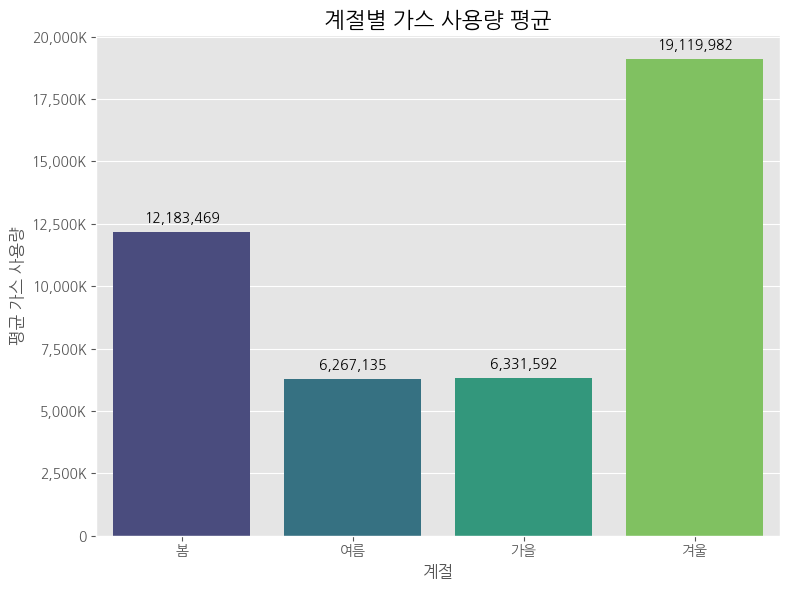

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import FuncFormatter

# --- 1. 폰트 및 스타일 설정 ---
# 폰트 설정 (NanumGothic 설치 및 런타임 재시작이 완료되었다고 가정)
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')

# 문제 1과 문제 2의 성공적인 실행으로 'df' DataFrame이 준비되었음을 가정합니다.

if 'df' in locals() or 'df' in globals():

    # ----------------------------------------------------------------------
    # 1. 가스 사용량 데이터 준비
    #    '가스_사용량' 컬럼을 직접 사용하여 분석 DataFrame을 준비합니다.
    # ----------------------------------------------------------------------

    # 필수 컬럼 존재 여부 확인
    if '가스_사용량' not in df.columns or 'season' not in df.columns:
        print("\n오류: '가스_사용량' 또는 'season' 컬럼이 DataFrame에 없습니다. 문제 2-1, 2-2를 다시 확인해 주세요.")
    else:
        # 분석에 필요한 컬럼만 선택하고, 결측치(NaN) 제거
        df_gas_analysis = df[['season', '가스_사용량']].dropna(subset=['가스_사용량'])

        # 2. 계절별 가스 사용량 평균 집계
        # 계절 순서를 명확히 지정하여 X축 순서 보장
        season_order = ['봄', '여름', '가을', '겨울']
        df_gas_seasonal = df_gas_analysis.groupby('season')['가스_사용량'].mean().reindex(season_order).reset_index()

        # 3. 막대 그래프 시각화 (FutureWarning 및 스타일 최적화)
        plt.figure(figsize=(8, 6))
        bars = sns.barplot(
            data=df_gas_seasonal,
            x='season',
            y='가스_사용량', # 새로운 컬럼 이름 사용
            hue='season',
            legend=False,
            palette='viridis' # 색상 팔레트 변경 (선택사항)
        )

        # 4. 그래프 제목 및 레이블 설정
        plt.title("계절별 가스 사용량 평균", fontsize=16)
        plt.xlabel("계절", fontsize=12)
        plt.ylabel("평균 가스 사용량", fontsize=12)

        # 5. Y축 포맷 개선: FuncFormatter를 사용하여 'K' (천) 단위로 포맷
        def k_formatter(x, pos):
            """Y축 값을 1,000 단위로 나누고 'K'를 붙여 포맷합니다."""
            if x >= 1000:
                return f'{int(x / 1000):,}K'
            return f'{int(x)}'

        formatter = FuncFormatter(k_formatter)
        plt.gca().yaxis.set_major_formatter(formatter)

        # 6. 각 막대에 구체적인 수치 표시
        for bar in bars.patches:
            height = bar.get_height()
            # 막대 위에 텍스트 추가: 정수 형태로 쉼표 포맷 적용
            plt.annotate(
                format(height, ',.0f'),
                (bar.get_x() + bar.get_width() / 2, height),
                ha='center',
                va='bottom',
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=10
            )

        plt.tight_layout()
        plt.savefig('계절별_가스_사용량_평균.png')
        plt.show()

else:
    print("오류: 'df' DataFrame이 정의되지 않았습니다. 문제 1, 2의 코드를 먼저 실행해 주세요.")